## A Deep Learning approach to detect deception using Audio Features

In [22]:
import sys
#sys.path.append('/home/adrikamukherjee/venv/lib/python3.6/site-packages')

In [23]:
import os, sys, glob, csv, numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf, IPython.display as ipd, keras
from sklearn import model_selection, preprocessing
import sklearn
from os import walk, path
from keras import models, layers, optimizers, preprocessing as KRSpreps, utils as KRSutils
#from tslearn import preprocessing as TSpreps, utils as TSutils

### "plot_acc_loss" function plots the validation and training accuracy && validation and training loss

In [130]:
def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

### Preparation of data before processing it

"direc" contains the path of frame wise Audio Features per video extracted using opensmile

Remove unnecesary columns

Seperate data and labels

In [25]:
direc = "C:/Users/Tilak Chan/OneDrive/Desktop/Tilak/BagOfLies/Audio_features/csv_framewise_audio"

In [26]:
df = pd.read_csv('C:/Users/Tilak Chan/OneDrive/Desktop/Tilak/BagOfLies/Audio_features/csv_framewise_audio/Audio_BagOfLies_User_0_run_0_video.csv')
df.columns

Index(['Unnamed: 0', 'name', 'pcm_intensity_sma_max', 'pcm_intensity_sma_min',
       'pcm_intensity_sma_range', 'pcm_intensity_sma_maxPos',
       'pcm_intensity_sma_minPos', 'pcm_intensity_sma_amean',
       'pcm_intensity_sma_linregc1', 'pcm_intensity_sma_linregc2',
       ...
       'F0env_sma_de_skewness', 'F0env_sma_de_kurtosis',
       'F0env_sma_de_quartile1', 'F0env_sma_de_quartile2',
       'F0env_sma_de_quartile3', 'F0env_sma_de_iqr1-2', 'F0env_sma_de_iqr2-3',
       'F0env_sma_de_iqr1-3', 'class', 'label'],
      dtype='object', length=992)

In [36]:
df_list, label_list = [], []
i = 0
for filename in glob.glob(os.path.join(direc, '*.csv')):
            df_individualfile = pd.read_csv(filename)
            count = len(df_individualfile.index)
            if(count>0):
                label = df_individualfile.loc[:, "label"].unique()[0]
                df_individualfile.drop(["name", "Unnamed: 0", "label","class"], axis = 1, inplace = True)
                df_individualfile.set_index(pd.date_range(start='2000-01-01', end='2020-01-12', 
                                                          periods = df_individualfile.shape[0]), inplace = True)
                df_individualfile.drop_duplicates(inplace = True)
                df_list.append(df_individualfile)
                label_list.append(label)
                i+=1

Hi +  0
Hi +  1
Hi +  2
Hi +  3
Hi +  4
Hi +  5
Hi +  6
Hi +  7
Hi +  8
Hi +  9
Hi +  10
Hi +  11
Hi +  12
Hi +  13
Hi +  14
Hi +  15
Hi +  16
Hi +  17
Hi +  18
Hi +  19
Hi +  20
Hi +  21
Hi +  22
Hi +  23
Hi +  24
Hi +  25
Hi +  26
Hi +  27
Hi +  28
Hi +  29
Hi +  30
Hi +  31
Hi +  32
Hi +  33
Hi +  34
Hi +  35
Hi +  36
Hi +  37
Hi +  38
Hi +  39
Hi +  40
Hi +  41
Hi +  42
Hi +  43
Hi +  44
Hi +  45
Hi +  46
Hi +  47
Hi +  48
Hi +  49
Hi +  50
Hi +  51
Hi +  52
Hi +  53
Hi +  54
Hi +  55
Hi +  56
Hi +  57
Hi +  58
Hi +  59
Hi +  60
Hi +  61
Hi +  62
Hi +  63
Hi +  64
Hi +  65
Hi +  66
Hi +  67
Hi +  68
Hi +  69
Hi +  70
Hi +  71
Hi +  72
Hi +  73
Hi +  74
Hi +  75
Hi +  76
Hi +  77
Hi +  78
Hi +  79
Hi +  80
Hi +  81
Hi +  82
Hi +  83
Hi +  84
Hi +  85
Hi +  86
Hi +  87
Hi +  88
Hi +  89
Hi +  90
Hi +  91
Hi +  92
Hi +  93
Hi +  94
Hi +  95
Hi +  96
Hi +  97
Hi +  98
Hi +  99
Hi +  100
Hi +  101
Hi +  102
Hi +  103
Hi +  104
Hi +  105
Hi +  106
Hi +  107
Hi +  108
Hi +  109
Hi +  110


In [37]:
df_list[320]

,pcm_intensity_sma_max,pcm_intensity_sma_min,pcm_intensity_sma_range,pcm_intensity_sma_maxPos,pcm_intensity_sma_minPos,pcm_intensity_sma_amean,pcm_intensity_sma_linregc1,pcm_intensity_sma_linregc2,pcm_intensity_sma_linregerrA,pcm_intensity_sma_linregerrQ,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
2000-01-01,4.143992e-07,0.0,4.143992e-07,1081.0,0.0,4.403980e-08,1.601195e-11,3.315969e-08,3.403962e-08,2.536528e-15,...,48.49173,6.972339,0.99662,9.994416,-2.726407,0.0,3.29979,2.726407,3.29979,6.026197


### Plot distribution of number of frames from each Audio File

count    327.000000
mean       2.981651
std       25.299912
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      325.000000
dtype: float64
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


<AxesSubplot:>

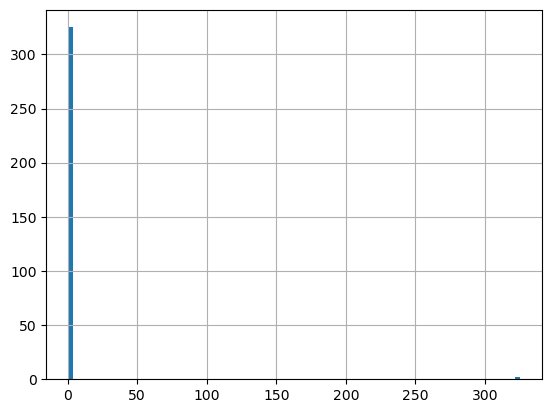

In [38]:
# This is just an analysis of number of rows per audio
### Find Min Max Mean number of frames
len_sequences = []
for one_seq in df_list:
    len_sequences.append(len(one_seq))
len_sequences = pd.Series(len_sequences)
print(len_sequences.describe())
print([val for val in [len_sequences.quantile(q = qtl) for qtl in np.arange(0.05, 1, 0.05)]])
len_sequences.hist(bins = 100)

### Upsample Data using linear method

In [39]:
import datetime
deltatime = (pd.to_datetime("2020-01-12") - pd.to_datetime("2000-01-01"))/1599
deltatime

Timedelta('4 days 13:48:31.069418386')

In [40]:
df_list_interpolated = []
for df in df_list:
    upsampled = df.resample(deltatime)
    df_interpolated = upsampled.interpolate(method = 'linear')
    #break
    df_list_interpolated.append(df_interpolated)

### Find those data which could not be sampled to 1600 frames && Remove them

In [49]:
for i, df in zip(np.arange(len(df_list_interpolated)), df_list_interpolated):
    if df.shape[0] != 1:
        print(df.shape, i)

(1600, 988) 324


In [50]:
df_list_interpolated.pop(324)
label_list.pop(324)

'Truthful'

### Check if all data is consistent and contains 1600 frames

In [51]:
for i, df in zip(np.arange(len(df_list_interpolated)), df_list_interpolated):
    if df.shape[0] != 1:
        print(df.shape, i)

### Scale upsampled data

In [110]:
df_list_audio_interpolated_scaled=[]

for df_individualfile_audio in df_list_interpolated:
    X_d = df_individualfile_audio
    temp = X_d.values 
    st_scaler = sklearn.preprocessing.StandardScaler()
    temp_scaled = st_scaler.fit_transform(temp)
    df_individualfile_audio=pd.DataFrame(temp_scaled)
    feature_list=df_individualfile_audio.columns.tolist()
    df_list_audio_interpolated_scaled.append(df_individualfile_audio)

### Convert data to numpy array && Reshape it

In [120]:
data_X = np.array(pd.concat(df_list_interpolated, axis = 0)).reshape(-1, 988, 1)
data_X.shape

(324, 988, 1)

### Encode lables

In [121]:
data_y = pd.Series(label_list).apply(lambda y: 1 if y == "Truthful" else 0)
data_y

0      1
1      0
2      0
3      0
4      0
      ..
319    0
320    1
321    0
322    1
323    0
Length: 324, dtype: int64

### "get_seq_model" is the Initial Model

In [124]:
def get_seq_model():
    model = models.Sequential()
    #model.add(layers.LSTM(units=64, recurrent_dropout=0.35, return_sequences=True, input_shape=(2048, 26)))
    #model.add(layers.LSTM(units=64, recurrent_dropout=0.35))
    model.add(layers.Flatten(input_shape=(988, 1)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001, decay=0.00001), metrics=['accuracy'])
    return model

### "get_seq_model1" is the Final Model Structure, with reduced complexity and l2 Regularization

In [125]:
from keras.regularizers import l2
from keras.optimizers import SGD,Adam
def get_seq_model1():
    #opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    opt=SGD(lr=0.0001, momentum=0.9)
    model = models.Sequential()
    model.add(layers.LSTM(units=64, recurrent_dropout=0.35, return_sequences=True, input_shape=(988, 1)))
    #model.add(layers.LSTM(units=64, recurrent_dropout=0.35))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [126]:
data_y=data_y.to_numpy()
type(data_y)

numpy.ndarray

### Split Train and Test data

In [127]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_X, data_y, test_size=0.1, random_state=1)
X_train.shape


(291, 988, 1)

### Early Stopping used && save the best model

In [128]:
import tensorflow

Epoch 1/200
5/5 [==============================] - ETA: 0s - loss: 0.8946 - accuracy: 0.4981
Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to best_model.h5
5/5 [==============================] - 13s 2s/step - loss: 0.8946 - accuracy: 0.4981 - val_loss: 0.8853 - val_accuracy: 0.4667
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: 0.8998 - accuracy: 0.4559
Epoch 2: val_accuracy did not improve from 0.46667
5/5 [==============================] - 9s 2s/step - loss: 0.8998 - accuracy: 0.4559 - val_loss: 0.8881 - val_accuracy: 0.4667
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: 0.8849 - accuracy: 0.5134
Epoch 3: val_accuracy did not improve from 0.46667
5/5 [==============================] - 8s 2s/step - loss: 0.8849 - accuracy: 0.5134 - val_loss: 0.8910 - val_accuracy: 0.4667
Epoch 4/200
5/5 [==============================] - ETA: 0s - loss: 0.8874 - accuracy: 0.5326
Epoch 4: val_accuracy improved from 0.46667 to 0.50000, saving m

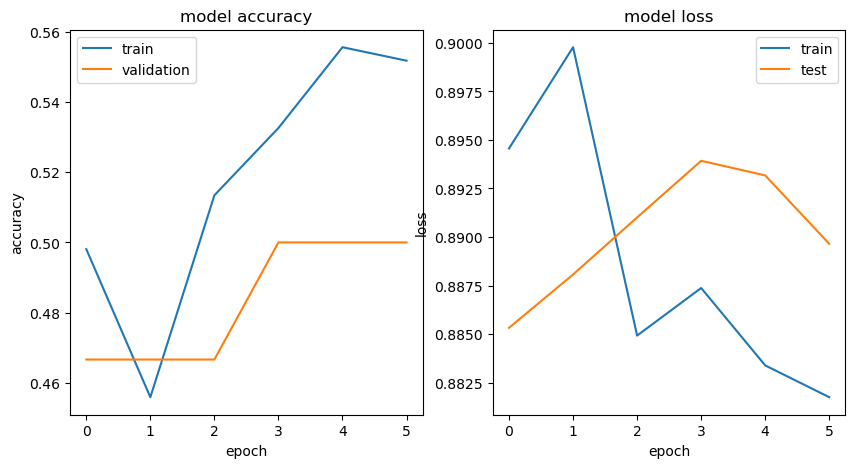

<Figure size 640x480 with 0 Axes>

In [133]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
model = get_seq_model1()
history = model.fit(X_train, y_train, batch_size=60, validation_split=0.1, epochs=200, verbose=1, callbacks=[es, mc])
plot_acc_loss(history)
plt.savefig('Loss_plot_Audio.png')
plt.show()

### Load the best model and calculate the test loss, test accuracy && Print Confusion Matrix

In [134]:
from keras.models import load_model
model = load_model('best_model.h5')
y_true = preprocessing.label_binarize(y_test, classes = [0, 1])
y_pred = model.predict(X_test)
results = model.evaluate(X_test, y_test)
print('test loss, test acc:', results)
y_pred_det = preprocessing.label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<0.65 else 1), classes = [0, 1])

conf = sklearn.metrics.confusion_matrix
print(conf(y_true, y_pred_det))
target_names = ['0', '1']

2/2 [==============================] - 1s 185ms/step - loss: 0.8794 - accuracy: 0.6364
test loss, test acc: [0.8794148564338684, 0.6363636255264282]
[[17  0]
 [16  0]]


### Calculate Metric Scores

In [135]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,cohen_kappa_score,roc_auc_score, accuracy_score
# Print f1, precision, and recall scores
y_pred_det = preprocessing.label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<0.5 else 1), classes = [0, 1])

prec = precision_score(y_true, y_pred_det , average="macro")
rec = recall_score(y_true, y_pred_det , average="macro")
fsc= f1_score(y_true, y_pred_det , average="macro")
# kappa
kappa = cohen_kappa_score(y_true, y_pred_det)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_true, y_pred_det)
print('ROC AUC: %f' % auc)
accu = accuracy_score(y_true, y_pred_det)

print('Precision: %f' % prec)
print('Recall: %f' % rec)
print('Fscore: %f' % fsc)
print('Accuracy: %f' % accu)

Cohens kappa: 0.287770
ROC AUC: 0.647059
Precision: 0.785714
Recall: 0.647059
Fscore: 0.590909
Accuracy: 0.636364


In [136]:
print(sklearn.metrics.classification_report(y_true, y_pred_det,target_names=target_names))
conf_res = conf(y_true, y_pred_det)
print("Precision in Detecting Deception: ", conf_res[1][1]/(conf_res[1][1]+conf_res[0][1]))
print("Recall in Detecting Deception: ", conf_res[1][1]/(conf_res[1][1]+conf_res[1][0]))

              precision    recall  f1-score   support

           0       1.00      0.29      0.45        17
           1       0.57      1.00      0.73        16

    accuracy                           0.64        33
   macro avg       0.79      0.65      0.59        33
weighted avg       0.79      0.64      0.59        33

Precision in Detecting Deception:  0.5714285714285714
Recall in Detecting Deception:  1.0


### Plot ROC Curve

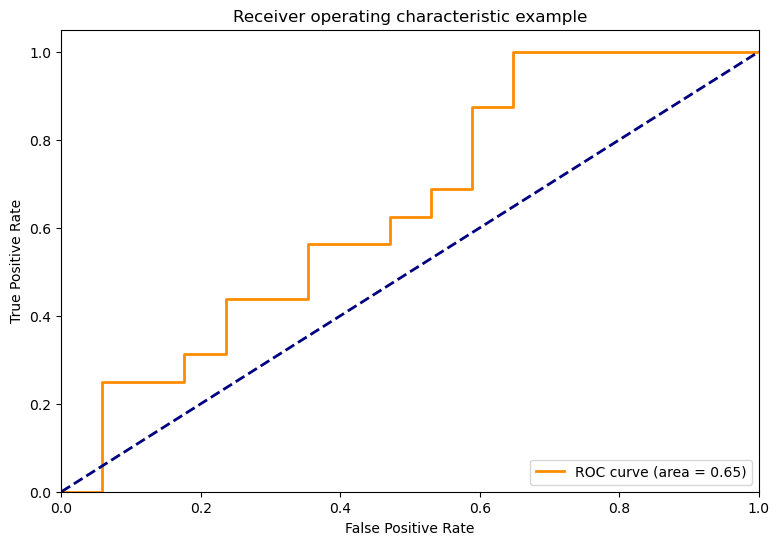

In [137]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
i=0
fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(9, 6))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()